## Chinese Character Detection

In [1]:
import os
import math
import json
import time
import pickle
import random
from PIL import Image
from datetime import datetime
from joblib import Parallel, delayed

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.path as mplpath
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.optim import Adam

%matplotlib inline

random.seed(42)

os.listdir("/scratch/lt2326-h21/a1/")

['images',
 'test_cls.jsonl',
 'ctw-annotations.tar.gz',
 'ctw-trainval-01-of-26.tar',
 'train.jsonl',
 'info.json',
 'val.jsonl']

## Part 1: data preparation

First get a list of all available files which are in the `images` directory

In [2]:
IMAGE_DIR = "/scratch/lt2326-h21/a1/images"
image_list = os.listdir(IMAGE_DIR)
image_list[:10]

['0001261.jpg',
 '1002235.jpg',
 '0000614.jpg',
 '1000699.jpg',
 '0001264.jpg',
 '1000606.jpg',
 '1002406.jpg',
 '0000853.jpg',
 '1001855.jpg',
 '0001414.jpg']

In [3]:
info = json.load(open("/scratch/lt2326-h21/a1/info.json"))

Check that all images have the same height and width in pixels:

In [4]:
print(set(i["height"] for i in info["train"]))
print(set(i["width"] for i in info["train"]))

{2048}
{2048}


Open train JSON file and check that the length is the same as `info.json`:

In [5]:
with open("/scratch/lt2326-h21/a1/train.jsonl") as trainfile:
    traindata = [json.loads(x) for x in trainfile]
len(traindata) == len(info["train"])

True

Filter down the entries in `traindata` to just those which are actually in `images`:

In [6]:
train_data = [item for item in traindata if item["file_name"] in image_list]
print(f"There are {len(train_data)} items in the data")

There are 845 items in the data


## Extract, process, and display polygons for a single image

In [ ]:
single_img = train_data[101]

print("File name:", single_img["file_name"])
print("Length of annotations (sentences):", len(single_img["annotations"]))

We can use the below function to convert the floating point numbers representing polygon coordinates into integers. Could also use the `round()` function but here we assume that we don't wish to round up or down.

In [ ]:
def truncate(number, digits = 0) -> int:
    stepper = 10.0 ** digits
    return int(math.trunc(stepper * number) / stepper)

Now we extract all polygons from the `single_img` data point:

In [ ]:
single_polygons = []

for sentence in single_img["annotations"]:
    for character in sentence:
        if character["is_chinese"]:
            truncated = []
            for (x, y) in character["polygon"]:
                truncated.append([truncate(x), truncate(y)])
            single_polygons.append(truncated)

print("The image contains", len(single_polygons), "polygons")

Sample of polygons:

In [ ]:
single_polygons[:10]

Now we convert the list of polygon coordinate lists into a numpy array and from that a Matplotlib Path object:

In [ ]:
list_of_paths = [mplpath.Path(arr) for arr in np.array(single_polygons)]
list_of_paths[0]

In [ ]:
grid = np.array([[[a,b] for b in list(range(2048))] for a in list(range(2048))])
grid = grid.reshape((2048 * 2048, 2))
grid.shape

In [ ]:
truth_values = np.array([False] * grid.shape[0])

for path in list_of_paths:
    truth_values += path.contains_points(grid)
    
contained_within_polygon = np.asarray(truth_values, int)
print("There are", contained_within_polygon.sum(), "coordinates which are contained within polygons")

In [ ]:
contained_within_polygon = contained_within_polygon.reshape((2048, 2048))
contained_within_polygon

Now that we have binary values for whether or not each coordinate in the image is part of a polygon, we can display this via Matplotlib:

In [ ]:
img = Image.open(os.path.join(IMAGE_DIR, single_img["file_name"]))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,8))

ax1.matshow(contained_within_polygon.transpose())
ax2.imshow(img)
ax3.imshow(img)

## Extract and process polygons for all images

In [7]:
GRID = np.array([[[a,b] for b in list(range(2048))] for a in list(range(2048))]).reshape((2048 * 2048, 2))

def truncate(number, digits = 0) -> int:
    stepper = 10.0 ** digits
    return int(math.trunc(stepper * number) / stepper)


def get_truncated_polygons(annotations):
    polygons = []

    for sentence in annotations:
        for character in sentence:
            if character["is_chinese"]:
                truncated = []
                for (x, y) in character["polygon"]:
                    truncated.append([truncate(x), truncate(y)])
                polygons.append(truncated)

    return polygons

def get_polygon_matrix(annotations):
    polygons = get_truncated_polygons(annotations)
        
    truth_values = np.array([False] * GRID.shape[0])
    list_of_paths = [mplpath.Path(arr) for arr in np.array(polygons)]
    
    for path in list_of_paths:
        truth_values += path.contains_points(GRID)
    
    truth_values = np.asarray(truth_values, int).reshape((2048, 2048)).T
    return truth_values
    
def convert_image_to_numpy_array(file_name):
    path = os.path.join(IMAGE_DIR, file_name)
    return np.array(Image.open(path), dtype=np.int)

def process_image_in_parallel(image):
    return (
        convert_image_to_numpy_array(image["file_name"]),
        get_polygon_matrix(image["annotations"]),
    )

The functions above take an `image` entry from the `train.jsonl` file and process the JSON contents. The `file_name` is used to load the image itself into memory before converting to a numpy array. Additionally, the `annotations` data is used to create a matrix of 0s and 1s indicating whether or not a specific pixel is part of a bounding box.

Processing all images individually takes far too long, so the [`joblib`](https://joblib.readthedocs.io/en/latest/parallel.html) library is used to run the processing in parallel threads for each subset of the data. This reduces the overall runtime of the processing from around 34 minutes to less than 600 seconds.

Each processed image returns a tuple, so the [`joblib`](https://joblib.readthedocs.io/en/latest/parallel.html) library returns a list of tuples, where the first element is the input data (`X`) and the second element is the output data (`y`)

In [8]:
start = time.time()
processed_data = Parallel(n_jobs=100)(delayed(process_image_in_parallel)(image) for image in tqdm(train_data))
end = time.time()

print("Processing data took", round(end - start, 0), "seconds")

100%|█████████████████████████████████████████████████| 845/845 [06:45<00:00,  2.08it/s]


Processing data took 526.0 seconds


Before splitting the data into training, testing, and validation sets, we must first convert the list of tuples into a list of lists. Here, the first list is all the input data points, while the second list is all the target data points.

In [9]:
X, y = list(map(list, zip(*processed_data)))

We then use the `train_test_split` function from Sklearn to split our data. To create the training, validation, and test sets, we call this function twice. Once to split the data 80:20 and again to split that 80 into 75:25. This leaves us with a training set comprising 60% of the data, as well as a validation and test set comprised of 20% each.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 

print(
    f" Train: {len(X_train)} {round(len(X_train)/len(X), 2)}\n",
    f"Validation: {len(X_val)} {round(len(X_val)/len(X), 2)}\n",
    f"Test: {len(y_val)} {round(len(y_val)/len(y), 2)}\n"
)

 Train: 507 0.6
 Validation: 169 0.2
 Test: 169 0.2



Finally, we should sense check the processing by inspecting a random sample of data points and ensuring both that the images look as we would expect, and that the bounding boxes are where they should be.

In [11]:
def sample_and_display(X_subset, y_subset):
    idx = random.sample(range(0, len(X_subset)), 1)[0]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

    ax1.imshow(X_subset[idx])
    ax2.matshow(y_subset[idx], cmap='Greys')

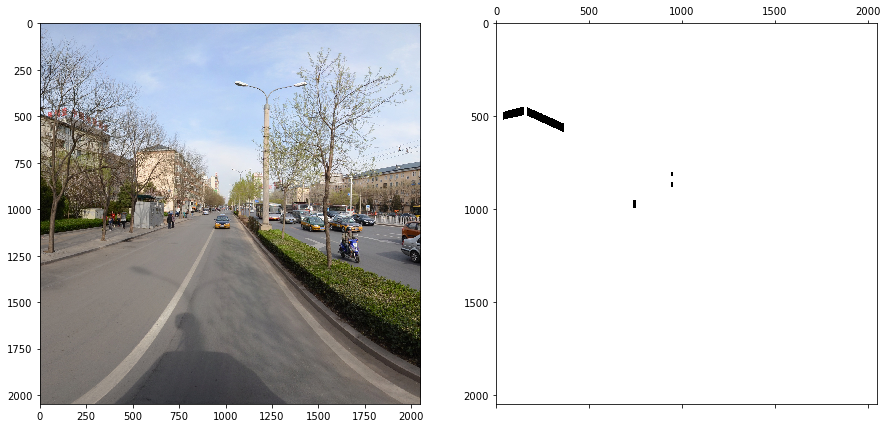

In [12]:
sample_and_display(X_train, y_train)

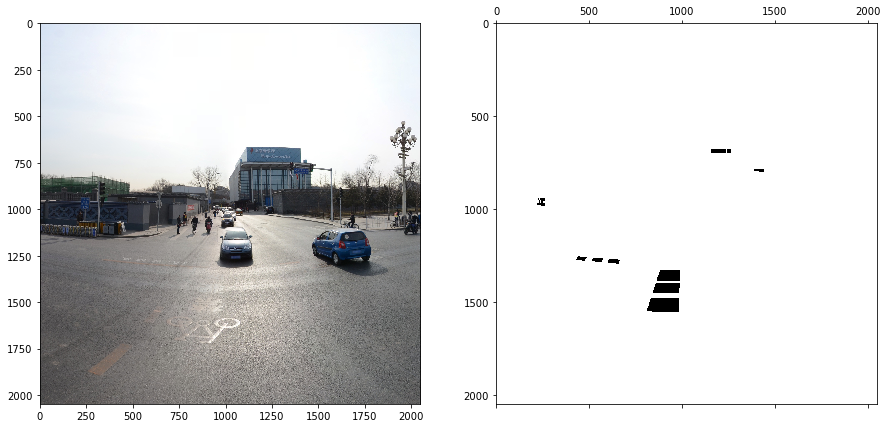

In [13]:
sample_and_display(X_val, y_val)

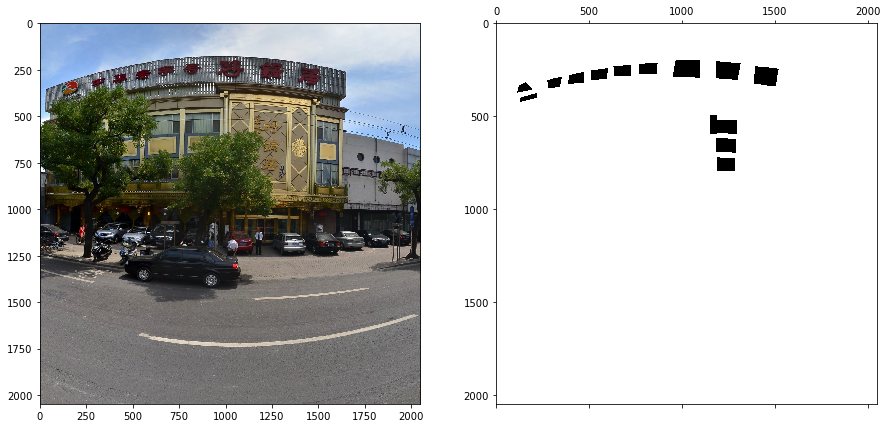

In [14]:
sample_and_display(X_test, y_test)

# Part 2: the models

At this point we have processed our data, but need an easy way to interface with the PyTorch models which will be defined later in this section. To achieve this, we implement a simple Dataset class. It would be possible to actually call the processing of each subset in the `__init__` method, but this isn't an important design decision.

In [15]:
import torch
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.Tensor(self.X[idx])
        y = torch.Tensor(self.y[idx].astype(int))
        return x, y

In [16]:
train_dataset = CustomImageDataset(X=X_train, y=y_train)
validation_dataset = CustomImageDataset(X=X_val, y=y_val)
test_dataset = CustomImageDataset(X=X_test, y=y_test)

Now that the datasets are set up, we can pass them into a DataLoader to batch and shuffle them for input into a model.

In [17]:
BATCH_SIZE = 2

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_batch_count = len(train_dataloader.dataset) // BATCH_SIZE
val_batch_count = len(validation_dataloader.dataset) // BATCH_SIZE
test_batch_count = len(test_dataloader.dataset) // BATCH_SIZE

In [18]:
device = torch.device("cuda") if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


Now that we have created some dataloaders, we can define the first model:

In [19]:
class NoPoolsAllowed(nn.Module):   
    def __init__(self):
        super(NoPoolsAllowed, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, (5,5), 3, (1,1))
        self.sigmoid1 = nn.Sigmoid()
        
        self.conv2 = nn.Conv2d(6, 12, (3,3), 2, (1,1))
        self.sigmoid2 = nn.Sigmoid()
        
        self.up1 = nn.Upsample((512,512))
        
        #self.conv3 = nn.Conv2d(3, 2, (3,3), 1, (1,1))
        self.conv3 = nn.Conv2d(12, 1, (3,3), 1, (1,1))
        self.up2 = nn.Upsample((2048,2048))
        #self.softmax = nn.Softmax(dim=1)
        self.sigmoid3 = nn.Sigmoid()
        
    # Defining the forward pass    
    def forward(self, x):
        x = x.permute((0,3,1,2))
        x = self.conv1(x)
        x = self.sigmoid1(x)
        x = self.conv2(x)
        x = self.sigmoid2(x)
        x = self.up1(x)
        x = self.conv3(x)
        x = self.up2(x)
        x = self.sigmoid3(x)
        
        return x

We then define the second model, which takes inspiration from [UNet](https://arxiv.org/abs/1505.04597) (albeit simplified so as not to break MLTGPU, which it did anyway):

In [20]:
class UnspiredNet(nn.Module):
    def __init__(self):
        super(UnspiredNet, self).__init__()
        # Encoder Block 1
        self.enc1_conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.enc1_bn1 = nn.BatchNorm2d(8)
        self.enc1_conv2 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.enc1_bn2 = nn.BatchNorm2d(8)
        self.enc1_relu = nn.ReLU()
        self.enc1_pool = nn.MaxPool2d((2, 2))
        
        # Encode Block 2
        self.enc2_conv1 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.enc2_bn1 = nn.BatchNorm2d(16)
        self.enc2_conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.enc2_bn2 = nn.BatchNorm2d(16)
        self.enc2_relu = nn.ReLU()
        self.enc2_pool = nn.MaxPool2d((2, 2))
        
        # Bottleneck
        self.bot_conv1 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bot_bn1 = nn.BatchNorm2d(32)
        self.bot_conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bot_bn2 = nn.BatchNorm2d(32)
        self.bot_relu = nn.ReLU()
        
        # Decoder Block 1
        self.dec1_up = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2, padding=0)
        self.dec1_conv1 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.dec1_bn1 = nn.BatchNorm2d(16)
        self.dec1_conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.dec1_bn2 = nn.BatchNorm2d(16)
        self.dec1_relu = nn.ReLU()
        
        # Decoder Block 2
        self.dec2_up = nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2, padding=0)
        self.dec2_conv1 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.dec2_bn1 = nn.BatchNorm2d(8)
        self.dec2_conv2 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.dec2_bn2 = nn.BatchNorm2d(8)
        self.dec2_relu = nn.ReLU()
        
        self.f_conv = nn.Conv2d(8, 1, kernel_size=1, padding=0)
        self.f_sig = nn.Sigmoid()
    
    def forward(self, inputs):
        inputs = inputs.permute((0,3,1,2))
        
        # Run through Encoder Block 1
        enc1_x = self.enc1_relu(self.enc1_bn2(self.enc1_conv2(self.enc1_bn1(self.enc1_conv1(inputs)))))
        enc1_p = self.enc1_pool(enc1_x)
        
        # Run through Encoder Block 2
        enc2_x = self.enc2_relu(self.enc2_bn2(self.enc2_conv2(self.enc2_bn1(self.enc2_conv1(enc1_p)))))
        enc2_p = self.enc2_pool(enc2_x)
        
        # Run through Bottleneck
        bot_x = self.bot_relu(self.bot_conv2(self.bot_bn1(self.bot_conv1(enc2_p))))
        
        # Run through Decoder Block 1
        dec1_x = self.dec1_relu(
            self.dec1_conv2(
                self.dec1_bn1(
                    self.dec1_conv1(
                        torch.cat( # The output of convTrans2D is concatenated with enc2_x -> output of last enc block
                            [
                                self.dec1_up(bot_x), # the first operation puts the bottleneck output through the convTrans2D
                                enc2_x
                            ],
                            axis=1
                        )
                    )
                )
            )
        )
        
        # Run through Decoder 2
        dec1_x = self.dec2_relu(
            self.dec2_conv2(
                self.dec2_bn1(
                    self.dec2_conv1(
                        torch.cat( # The output of convTrans2D is concatenated with enc2_x -> output of last enc block
                            [
                                self.dec2_up(dec1_x), # the first operation puts the bottleneck output through the convTrans2D
                                enc1_x
                            ],
                            axis=1
                        )
                    )
                )
            )
        )
        
        # Run through Output
        conv = self.f_conv(dec1_x)
        return self.f_sig(conv)


Before training the model, let's define a helper function that will run the training and validation for us. The function takes a name, a model class, a device, an optimizer, a learning rate and the number of epochs and does all the training loop for us, before running through the validation data. For both datasets, the function stores the average loss per epoch and, along with the model parameters, saves these to a unique name.

In [21]:
def train_model(name, model, device, optimizer=Adam, loss_fn=nn.BCELoss, learning_rate=0.01, n_epochs=20):
    this_model = model()

    model = nn.DataParallel(model, device_ids=[1, 3])
    this_model.to(device)

    loss_fn = loss_fn()
    opt = optimizer(this_model.parameters(), lr=learning_rate)
    history = {"train_loss": [], "val_loss": []}

    for e in range(0, n_epochs):
        print(f"Starting epoch #{e}:", datetime.utcnow())
        start = time.time()
        this_model.train()

        train_loss = 0
        val_loss = 0

        for (x, y) in train_dataloader:
            (x, y) = (x.to(device), y.float().to(device))

            pred = this_model(x)
            loss = loss_fn(pred.squeeze(dim=1), y)

            opt.zero_grad()
            loss.backward()
            opt.step()

            train_loss += loss

        with torch.no_grad():
            this_model.eval()

            for (x, y) in validation_dataloader:
                (x, y) = (x.to(device), y.float().to(device))

                pred = this_model(x)
                val_loss += loss_fn(pred.squeeze(dim=1), y)

        avg_train_loss = train_loss / train_batch_count
        avg_val_loss = val_loss / val_batch_count
        
        param_save_path = f"./parameters_{name}_{optimizer.__name__}_{learning_rate}_epoch#{e}.pth"
        torch.save(this_model, param_save_path)

        history["train_loss"].append(float(avg_train_loss.cpu().detach().numpy()))
        history["val_loss"].append(float(avg_val_loss.cpu().detach().numpy()))

        print(f"[INFO] EPOCH: {e + 1}/{n_epochs}")
        print(f"Average train loss: {float(avg_train_loss.detach().cpu().numpy())}")
        print(f"Average validation loss: {float(avg_val_loss.detach().cpu().numpy())}")
        
    param_save_path = f"./parameters_{name}_{optimizer.__name__}_{learning_rate}_{n_epochs}.pth"
    history_save_path = f"./history_{name}_{optimizer.__name__}_{learning_rate}_{n_epochs}.pic"
    
    torch.save(this_model, param_save_path)
    pickle.dump(history, open(history_save_path, "wb"))
    
    print(f"Parameters saved to path: {param_save_path}")
    print(f"History saved to path: {history_save_path}")

Now let's train the models:

In [ ]:
train_model(
    name="NoPoolsAllowed",
    model=NoPoolsAllowed,
    device=device,
    optimizer=Adam,
    loss_fn=nn.BCELoss,
    learning_rate=0.01,
    n_epochs=20,
)


In [21]:
train_model(
    name="UnspiredNet",
    model=UnspiredNet,
    device=device,
    optimizer=Adam,
    loss_fn=nn.BCELoss,
    learning_rate=0.01,
    n_epochs=5,
)


Starting epoch #0: 2021-10-18 22:50:33.954333


/usr/local/lib64/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[INFO] EPOCH: 1/5
Average train loss: 0.046420250087976456
Average validation loss: 0.030884623527526855
Starting epoch #1: 2021-10-18 23:42:37.495715
[INFO] EPOCH: 2/5
Average train loss: 0.02896125614643097
Average validation loss: 0.028615299612283707
Starting epoch #2: 2021-10-19 00:34:25.447796
[INFO] EPOCH: 3/5
Average train loss: 0.026527248322963715
Average validation loss: 0.02534274384379387
Starting epoch #3: 2021-10-19 01:26:13.515161
[INFO] EPOCH: 4/5
Average train loss: 0.025552082806825638
Average validation loss: 0.02383493259549141
Starting epoch #4: 2021-10-19 02:17:54.086965
[INFO] EPOCH: 5/5
Average train loss: 0.024588730186223984
Average validation loss: 0.02403300814330578
Parameters saved to path: ./parameters_UnspiredNet_Adam_0.01_5.pth
History saved to path: ./history_UnspiredNet_Adam_0.01_5.pic


## Part 3: testing and evaluation

In [22]:
def get_predictions(raw_preds):
    batch_predictions = []
    for item in raw_preds:
        batch_predictions.append(np.asarray(item.detach().cpu().numpy() > THRESHOLD, int))
    return batch_predictions


def get_evaluation_variables(parameter_file, device="cuda:2"):
    this_model = torch.load(parameter_file).to(device)
    
    with torch.no_grad():
        this_model.eval()
        
        test_images = []
        test_preds = []
        test_truth = []
        
        #DEBUG
        raw_preds = []

        loss_fn = nn.BCELoss()
        test_loss = 0

        for (x, y) in test_dataloader:
            (x, y) = (x.to(device), y.to(device))

            batch_preds = this_model(x)
            test_loss += loss_fn(batch_preds.squeeze(dim=1), y)
            
            test_images.append(x.detach().cpu())
            
            #DEBUG
            raw_preds.append(batch_preds.squeeze(dim=1))
            test_preds.extend(get_predictions(batch_preds.squeeze(dim=1)))
            test_truth.append(y.detach().cpu())
           
    
        avg_test_loss = test_loss / test_batch_count
        test_preds = test_preds # this is the problematic one
        test_images = test_images # np.concat
        test_truth = test_truth # np.concat
        
        #DEBUG
        raw_preds = raw_preds # np.concatenate
    
    return test_images, test_preds, test_truth, avg_test_loss, raw_preds


def get_evaluation_metrics(preds, ground_truth, avg_test_loss, device="cpu"):
    prediction_tensor = torch.Tensor(preds).to(device)
    ground_truth_tensor = torch.Tensor(ground_truth).to(device)
    confusion_vector = prediction_tensor / ground_truth_tensor

    tp = torch.sum(confusion_vector == 1).item()
    fp = torch.sum(confusion_vector == float('inf')).item()
    tn = torch.sum(torch.isnan(confusion_vector)).item()
    fn = torch.sum(confusion_vector == 0).item()

    accuracy = (tp + tn) / (tp + fp + tn + fn)
    mse = mean_squared_error(ground_truth.reshape(169*2048*2048), preds.reshape(169*2048*2048))
    recall = tp / (tp + fn)

    try:
        precision = tp / (tp + fp)
    except ZeroDivisionError:
        precision = 0

    try:
        f1_score = 2 * ((precision * recall) / (precision + recall))
    except ZeroDivisionError:
        f1_score = 0

    return pd.DataFrame({
        "Average Test Loss": avg_test_loss.item(),
        "Accuracy": accuracy,
        "Recall": recall,
        "Precision": precision,
        "F1-Score": f1_score,
        "Mean Squared Error": mse,
    }, index=["Test Metrics"]).round(4)


def display_training_validation_loss(history_file):
    history = pd.DataFrame(pickle.load(open(history_file, "rb")))
    history["Epoch"] = [e for e in range(1, len(history) + 1)]
    history = history.rename(columns={"train_loss": "Train Loss", "val_loss": "Validation Loss"})

    plt.plot("Epoch", "Train Loss", data=history, marker='', color='skyblue', linewidth=2)
    plt.plot("Epoch", "Validation Loss", data=history, marker='', color='olive', linewidth=2)

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()
    
def visualise_probability_map(images, preds, ground_truth, idx=None, save_name=None):
    if not idx:
        idx = random.sample(range(0, len(images)), 1)[0]
    print(f"Showing image #{idx}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

    cmap = matplotlib.colors.ListedColormap([[0, 0, 0, 0], 'lawngreen'])
    bounds = np.array([0., 0.5, 1.],dtype=object,)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

    ax1.imshow(images[idx].astype(int))
    ax1.imshow(preds[idx], interpolation='none', cmap=cmap, alpha=1);
    ax1.set_title("Predicted")

    ax2.imshow(images[idx].astype(int))
    ax2.imshow(ground_truth[idx], interpolation='none', cmap=cmap, alpha=0.8)
    ax2.set_title("Ground Truth");
    
    if save_name:
        fig.savefig(f"{save_name}_{idx}.png")

NoPoolsAllowed generates few predictions, so visualisation run on a random image may not show any pixel probabilities overlayed on that image. The code below shows uses an array of random 0s and 1s to how that the code does work:

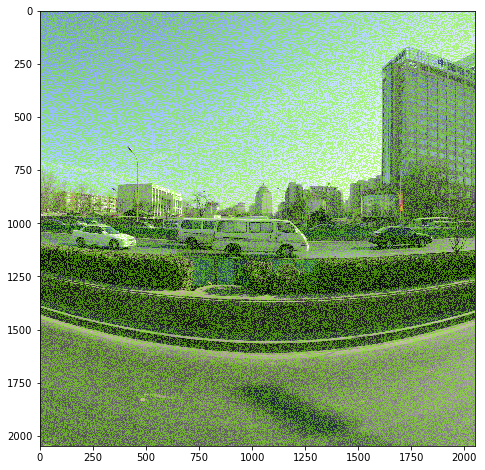

In [42]:
y_random = np.random.choice([0, 1], size=(2048,2048))

cmap = matplotlib.colors.ListedColormap([np.array([0, 0, 0, 0]), 'lawngreen'])
bounds = [0., 0.5, 1.]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(8,8))
plt.imshow(X_test[0])
plt.imshow(y_random, interpolation='none', cmap=cmap, norm=norm, alpha=0.5);

## Evaluation for model 1

In [23]:
THRESHOLD = 0.005

images, preds, ground_truth, avg_test_loss, debug_preds = get_evaluation_variables(
    parameter_file="./parameters_NoPoolsAllowed_Adam_0.01_20.pth", 
)

In [24]:
images_np = np.concatenate([img.detach().cpu().numpy() for img in images])
ground_truth_np = np.concatenate([gt.detach().cpu().numpy() for gt in ground_truth])
preds = np.stack(preds)

In [25]:
get_evaluation_metrics(preds, ground_truth_np, avg_test_loss)

,Average Test Loss,Accuracy,Recall,Precision,F1-Score,Mean Squared Error
Test Metrics,0.0344,0.9809,0.0055,0.0022,0.0031,0.0191


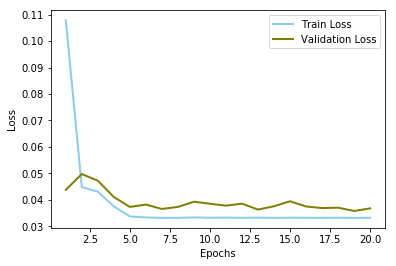

In [26]:
display_training_validation_loss(history_file="history_NoPoolsAllowed_Adam_0.01_20.pic")

Showing image #23


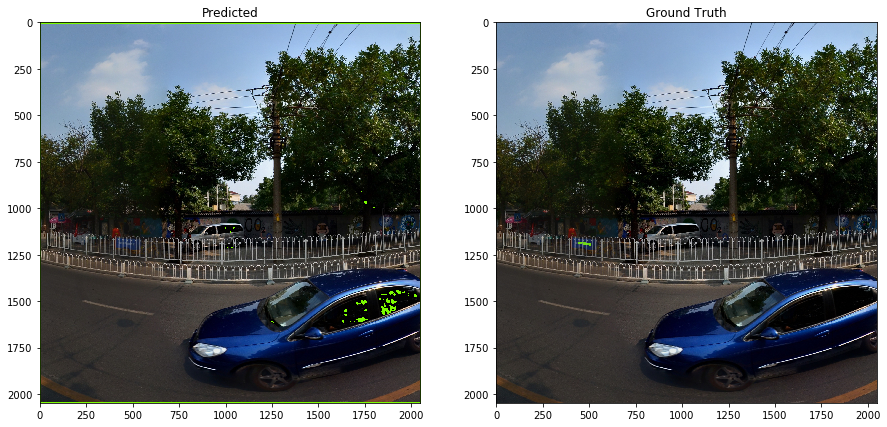

In [41]:
visualise_probability_map(images_np, preds, ground_truth_np,idx=23, save_name="NoPoolsAllowed_Adam_0.01_20")

## Evaluation for model 2

In [20]:
THRESHOLD = 0.05

images, preds, ground_truth, avg_test_loss, debug_preds = get_evaluation_variables(
    parameter_file="./parameters_UnspiredNet_Adam_0.01_5.pth", 
)

/usr/local/lib64/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [21]:
images_np = np.concatenate([img.detach().cpu().numpy() for img in images])
ground_truth_np = np.concatenate([gt.detach().cpu().numpy() for gt in ground_truth])
preds = np.stack(preds)

In [22]:
get_evaluation_metrics(preds, ground_truth_np, avg_test_loss)

,Average Test Loss,Accuracy,Recall,Precision,F1-Score,Mean Squared Error
Test Metrics,0.0273,0.9832,0.3474,0.1259,0.1848,0.0168


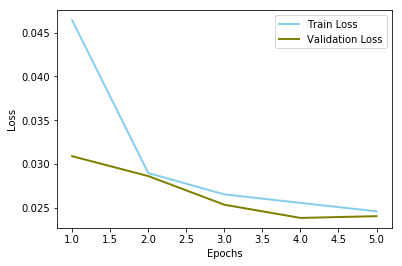

In [23]:
display_training_validation_loss(history_file="history_UnspiredNet_Adam_0.01_5.pic")

Showing image #108


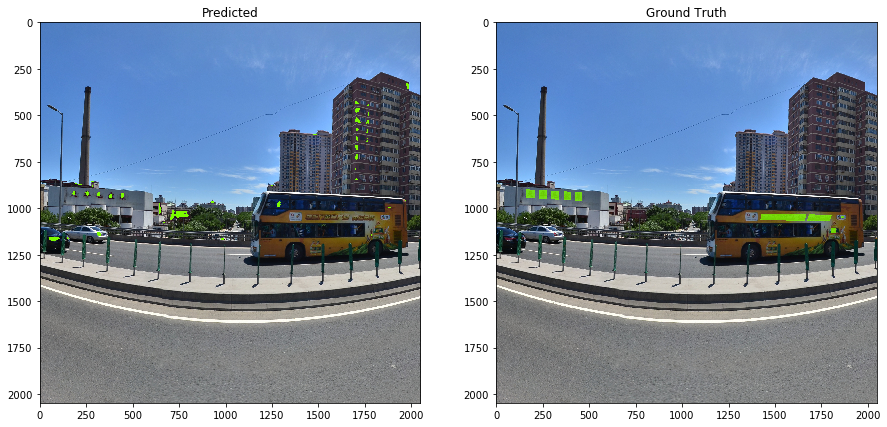

In [38]:
visualise_probability_map(images_np, preds, ground_truth_np, idx=108, save_name="UnspiredNet_Adam_0.01_5")

In [ ]:
del images
del preds
del ground_truth
del avg_test_loss

In [ ]:
# To free up GPU space, manually do some garbage collection then empty torch cache
import gc
gc.collect()
torch.cuda.empty_cache()